In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime, timedelta
from tqdm.notebook import tqdm

In [2]:
pd.set_option('display.max_rows', 500)
file_path = 'C:/Users/Jacob/Documents/datasets/amsterdamumcdb-1.0.2/'
save_path = 'C:/Users/Jacob/Documents/datasets/amsterdamumcdb-1.0.2-processed/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [3]:
adm = pd.read_csv(os.path.join(file_path, 'admissions.csv'))
adm.head()

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,destination,gender,agegroup,dateofdeath,weightgroup,weightsource,heightgroup,heightsource,specialty
0,0,0,1,IC,0,NaN,0,2003-2009,148800000,42,16,Vrouw,80+,NaN,60-69,Anamnestisch,160-169,Anamnestisch,Cardiochirurgie
1,1,1,1,IC,0,NaN,0,2010-2016,96120000,26,15,Man,60-69,NaN,70-79,Anamnestisch,170-179,Anamnestisch,Cardiochirurgie
2,2,2,1,IC,1,Eerste Hulp afdeling zelfde ziekenhuis,0,2010-2016,84240000,23,15,Man,60-69,NaN,90-99,Anamnestisch,180-189,Anamnestisch,Cardiochirurgie
3,3,3,1,IC,0,NaN,0,2003-2009,84900000,23,14,Man,50-59,NaN,90-99,NaN,180-189,Gemeten,Cardiochirurgie
4,4,4,1,IC&MC,0,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,180900000,50,19,Man,70-79,NaN,70-79,Anamnestisch,170-179,Anamnestisch,Cardiochirurgie


In [4]:
df = adm.groupby('patientid')['admissioncount'].nunique()
print(adm.shape)
adm = adm.copy().loc[adm['patientid'].isin(list(df[df==1].index))]
print(adm.shape)

(23106, 19)
(17789, 19)


In [5]:
lst_cols = ['admissionid', 'itemid', 'valueid', 'measuredat']
lst = pd.read_csv(os.path.join(file_path, "listitems.csv"), encoding='latin-1', usecols=lst_cols)
print(lst.shape)
lst = lst.loc[lst["admissionid"].isin(adm["admissionid"])]
print(lst.shape)
lst.head()

(30744065, 4)
(21011686, 4)


,admissionid,itemid,valueid,measuredat
0,0,6671,1,20520000
1,0,6671,1,22320000
2,0,6671,1,25920000
3,0,6671,1,29520000
4,0,6671,1,33120000


In [7]:
lst = lst.loc[(lst['itemid'] == 6671) & (lst['valueid'] == 13)]  # Hartritme and Atr fib
print(lst.shape)

(122123, 4)


In [8]:
print(adm.shape)
adm = adm.loc[adm["admissionid"].isin(lst["admissionid"])]
print(adm.shape)

(17789, 19)
(2808, 19)


In [11]:
num_file = os.path.join(file_path, "numericitems.csv")
num_cols = ["admissionid", "item", "value", "unit", "measuredat"]
chunksize = 100000
num = []
# ***reading chartevents is slow***
# Documentation says `numericitems.csv` has 977625612 rows
for chunk in tqdm(pd.read_csv(num_file, usecols=num_cols, chunksize=chunksize, encoding='latin-1'), total=(977625612//chunksize)+1, smoothing=0.01):
    chunk = chunk.loc[chunk["admissionid"].isin(adm["admissionid"])]
    chunk = chunk.loc[0 < chunk["measuredat"]]
    num.append(chunk)

  0%|          | 0/9777 [00:00<?, ?it/s]

In [12]:
num = pd.concat(num)
print(num.shape)
num.head()

(284162046, 5)


,admissionid,item,value,unit,measuredat
201345,6,Hartfrequentie,96.0,/min,2340000
201346,6,Hartfrequentie,98.0,/min,5940000
201347,6,Hartfrequentie,96.0,/min,9540000
201348,6,Hartfrequentie,107.0,/min,13140000
201349,6,Hartfrequentie,125.0,/min,16740000


In [13]:
num.to_csv(os.path.join(save_path, "esicm_numericitems.csv"))

In [14]:
# Keep 100 most frequent items in listitems
num = num.loc[num["item"].isin(num["item"].value_counts().index.to_list()[:100])]
print(num.shape)

(278175908, 5)


In [15]:
num.groupby("item")["unit"].value_counts(dropna=False)

item                              unit    
ABP diastolisch                   mmHg        8922976
ABP gemiddeld                     mmHg        8921535
ABP systolisch                    mmHg        8923073
Act.HCO3 (bloed)                  mmol/l       158103
Adem Frequentie (Set)             /min        1259442
Ademfreq.                         /min        4931281
Ademfrequentie Monitor            None        6094242
B.E. (bloed)                      mmol/l       157446
Backup druk (Set)                 cmH2O       3273781
Barometer druk                    mbar        4859873
CO2 min prod                      ml/min      4618103
CO2 tidal productie               ml          4618871
CVD                               mmHg         146631
CVDm-gekoppeld                    mmHg        1394452
Cdyn                              ml/cmH2O    4760787
Eind exp. druk                    cmH2O       4934592
Eind insp. cyclus (Set)           Geen        3817341
End tidal CO2 concentratie        mmHg 

In [16]:
stats = num.groupby("item")["value"].describe(percentiles=[0.05, 0.5, 0.95])
stats

,count,mean,std,min,5%,50%,95%,max
item,,,,,,,,
ABP diastolisch,8922976.0,59.997742,19.015692,-3.268400e+04,42.00,58.000000,84.000000,4.046000e+03
ABP gemiddeld,8921535.0,81.718376,2167.563811,-1.190000e+02,59.00,78.000000,110.000000,6.395322e+06
ABP systolisch,8923073.0,125.861625,56.966914,-1.000000e+00,87.00,123.000000,173.000000,1.503140e+05
Act.HCO3 (bloed),158103.0,38.346683,5029.843056,-2.290000e+01,16.90,25.600000,34.599998,1.999999e+06
Adem Frequentie (Set),1259442.0,22.182787,6.394675,0.000000e+00,13.00,22.000000,32.000000,2.050000e+02
Ademfreq.,4931281.0,23.062166,7.615119,0.000000e+00,12.00,22.000000,37.000000,2.810000e+02
Ademfrequentie Monitor,6094242.0,20.503294,8.223662,-1.000000e+00,8.00,20.000000,34.000000,2.322000e+03
B.E. (bloed),157446.0,3.206959,4.836832,-1.430000e+02,-5.20,3.200000,10.500000,1.170000e+02
Backup druk (Set),3273781.0,13.796288,5.878765,0.000000e+00,5.00,13.000000,20.000000,8.180000e+02


In [18]:
for item, lb, ub in tqdm(zip(stats.index, stats["5%"], stats["95%"]), total=100):
    num = num.drop(num.loc[(num["item"] == item) & ((num["value"] < lb) | (ub < num["value"]))].index)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
num.shape

(274566505, 5)

KeyboardInterrupt: 

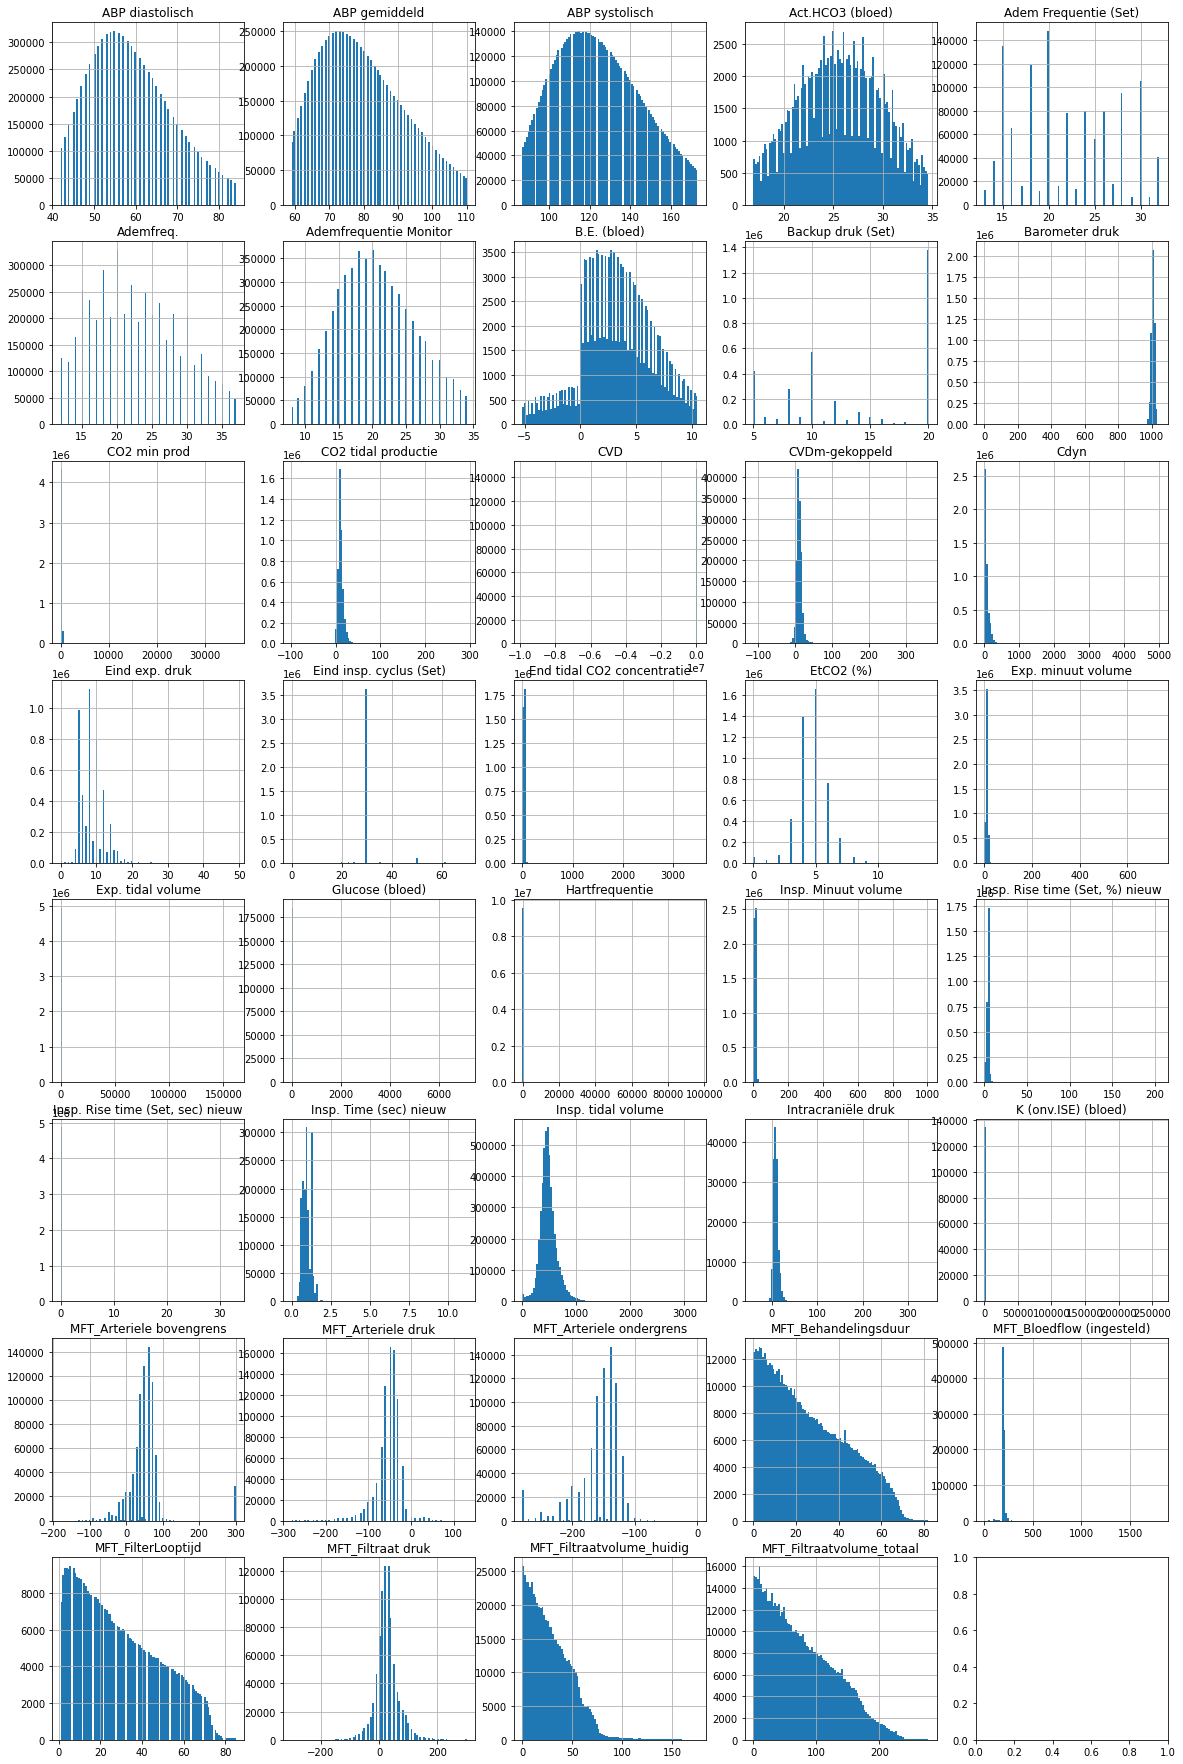

In [23]:
plt.figure(figsize=(20, 80))
for i, item in enumerate(sorted(num["item"].unique())):
    plt.subplot(20, 5, 1+i)
    num["value"][num["item"] == item].hist(bins=100)
    plt.title(item)